In [1]:
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from string import punctuation
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from collections import defaultdict
from nltk.corpus import wordnet as wn
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib
import os
import csv

In [120]:
folder2 = "C:/Users/blanc/OneDrive/Documentos/1. MSc Computer Science/3rd semester/Social graphs and interactions/TheOfficeWebsite/docs/images/"

<p style="font-family:Muro;font-weight:bold;font-size:35px;margin:10px 0px 10px 0px;color:#ADD8E6">Wordclouds</p>

## On the dialogue

In [3]:
script_path = "Data/the-office-lines-script.xlsx"
df_dialog = pd.read_excel(script_path, index_col = "id")

In [4]:
# We remove the parenthetical. That is, the text into parenthesis that provides directions for the characters.
parentheticals_regex = r"(\[.*?\])"

def remove_parentheticals(line):
    line = str(line)
    parentheticals = re.findall(parentheticals_regex,line)
    
    for parenthetical in parentheticals:
        line = line.replace(parenthetical, "")
    
    return line

In [5]:
def get_character_lines_per_episode(character, remove_par = True):

    df_aired_lines = df_dialog.loc[df_dialog.deleted == False]
    df_character = df_aired_lines.loc[df_aired_lines.speaker == character]
    
    character_season_lines = {}

    for season in df_character.season.unique():
        df_season = df_character.loc[df_character.season == season]
        character_episode_lines = {}
        
        for episode in df_season.episode.unique():
            df_episode = df_season.loc[df_season.episode == episode]           
            character_episode_lines[episode] = list(df_episode.line_text)
            
            if remove_par:
                character_episode_lines[episode] = [remove_parentheticals(line) for line in list(df_episode.line_text)]
        
        character_season_lines[season] = character_episode_lines
        
    return character_season_lines

In [6]:
def get_character_lines_per_season(character):
    character_season_lines = get_character_lines_per_episode(character)       
    return {season:[line for episode in episodes.values() for line in episode] for (season, episodes) in character_season_lines.items()}

In [7]:
def get_character_lines_series(character):  
    dialog = get_character_lines_per_season(character)
    return [line for season in dialog.values() for line in season]

In [8]:
def un_pack_episode_lines(character):
    episode_lines = get_character_lines_per_episode(character)   
    return [lines for episode in episode_lines.values() for lines in episode.values()]

In [9]:
sw = stopwords.words('english')
tk = nltk.WordPunctTokenizer()

def tokenize_text(text):
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', punctuation.replace("'","")))
    
    #Generating the tokens
    tokens = tk.tokenize(text)
    
    #Removing all the stopwords
    new_tokens = [token.lower() for token in tokens if token not in sw]
    
    #Generating the lemmatizer and returning the output
    wnl = nltk.WordNetLemmatizer()
    output = [wnl.lemmatize(t) for t in new_tokens]
    
    return output

def tokenize_sentences(sentences):
    return tokenize_text(" ".join(sentences))

In [10]:
def tc(token_list):
    tc = {}
    tokens = [word for tokens in token_list for word in tokens]
    for key, value in nltk.FreqDist(tokens).items():
        tc[key] = value
    return tc

def idf(texts):
    text = nltk.TextCollection(texts)
    idf = {}
    for word in text:
        idf[word] = text.idf(word)
    return idf

def idf_log(token_list):
    unique_tokens = np.unique([word for tokens in token_list for word in tokens])
    idf = {}
    n_documents = len(token_list)
        
    for word in unique_tokens:
        n_documents_with_word = [1 for document in token_list if word in document]
        idf[word] = np.log((n_documents)/(len(n_documents_with_word)+1))
        
    return idf

def tc_logidf(tokens):
    tc_ = tc(tokens)
    idf_log_ = idf_log(tokens)  
    return {word:tc_[word]*math.ceil(idf_log_[word]) for word in tc_.keys()}
        
def tc_idf(tokens):
    tc_ = tc(tokens)
    idfs = idf(tokens)
    tc_idf = {}
    tokens = [word for token_list in tokens for word in token_list]
    for word in tokens:
        tc_idf[word] = int(math.ceil(idfs[word])) * tc_[word]
    return tc_idf

In [124]:
characters_to_analyze = ["Michael","Jim", "Dwight", "Pam", "Andy"]
def get_tokens():
    characters_tokens = {}
    
    for character in characters_to_analyze:
        texts = un_pack_episode_lines(character)
        tokens = [tokenize_sentences(text) for text in texts]

        characters_tokens[character] = tokens
    return characters_tokens

In [125]:
'''
characters_tokens = get_tokens()
with open('Data/characters_tokens.pickle', 'wb') as handle:
    pickle.dump(characters_tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

"\ncharacters_tokens = get_tokens()\nwith open('Data/characters_tokens.pickle', 'wb') as handle:\n    pickle.dump(characters_tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)\n"

In [126]:
with open('Data/characters_tokens.pickle', 'rb') as handle:
    characters_tokens = pickle.load(handle)

In [127]:
tc_idfs = {character:tc_idf(characters_tokens[character]) for character in characters_to_analyze}

In [128]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors2 = ["darkorange", "gold", "lime", "forestgreen", "deepskyblue", "blue", "darkviolet", "hotpink", "red"]
colors = ["darkblue", "mediumblue", "blue", "indigo", "purple", "darkviolet", "darkgreen", "green"]
newcmp = ListedColormap(colors)

In [129]:
from PIL import Image
link_mask = np.array(Image.open("images/speech-bubble.png"))
common_words = ["oh", "yeah", "ok", "dont", "hey", "okay", "know"]

def make_wordcloud_image(character):
    words_by_weight = [[word]*weight for (word, weight) in tc_idfs[character].items() if word not in common_words]
    output = " ".join([word for lst in words_by_weight for word in lst])

    wordcloud = WordCloud(width = 1600, height= 800,max_words=150, background_color="white", collocations=False, min_font_size=10, mask = link_mask, contour_width=3, contour_color='black', colormap=ListedColormap(colors2)).generate(output)
    plt.figure(figsize=[10,5])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(folder + f"{character}.png")
   # plt.title(f"Wordcloud for {character}")
    #plt.figtext(0.5, 0, f"Figure; {character.capitalize()}; WordCloud", wrap=True, horizontalalignment='center', fontsize=20)
    plt.show()

In [130]:
def get_toke_text_dialog(character):
    tc_idfs = tc_idf(characters_tokens[character])    
    words_by_weight = [[word]*weight for (word, weight) in tc_idfs.items() if "v" not in [t.pos() for t in wn.synsets(word)] and word not in common_words]
    return " ".join([word for lst in words_by_weight for word in lst])

In [131]:
def make_wordcloud(output, character):
      
    wordcloud = WordCloud(width = 1600, height= 800,max_words=150, background_color="white", min_font_size=10,collocations=False, contour_width=3, colormap=newcmp).generate(output)       
    plt.figure(figsize=[10,5])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(folder + f"{character}_wiki.png")
    #plt.title(f"Wordcloud for {character}")
    plt.show()

Wordcloud for Michael


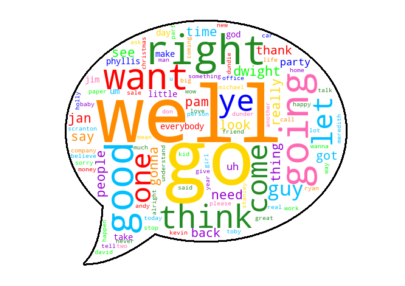

Wordcloud for Jim


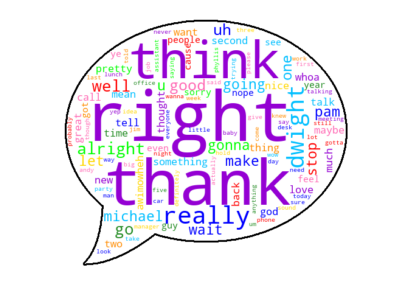

Wordcloud for Dwight


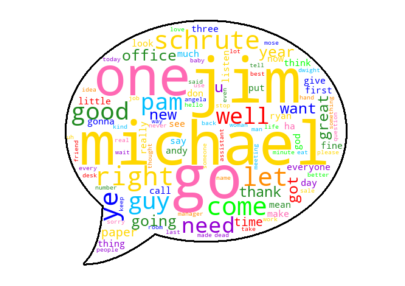

Wordcloud for Pam


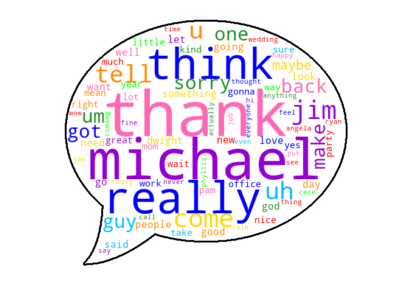

Wordcloud for Andy


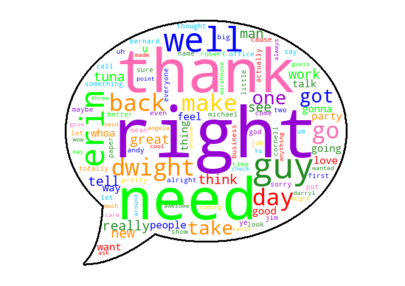

In [132]:
for character in characters_to_analyze:
    #output = get_toke_text_dialog(character)
    print(f"Wordcloud for {character}")
    make_wordcloud_image(character)

## On the wiki pages

In [20]:
G = nx.readwrite.adjlist.read_adjlist("Data/GCC.gz")
surnames_and_names = "_".join(G.nodes()).split("_")
words_to_remove = ["episode", "season", "later", "character", "tell", "back", "one", "two", "often", "series", "airdate", "tv", "u", "networknbc", "fischer", "jenna"] + [c.lower() for c in surnames_and_names] + sw

In [21]:
start_end = {"Michael_Scott":
                         ("==Character information, arc, and backstory==",
                         "==Relationships=="),
             "Jim_Halpert":
                         ("",
                         "== Appearances=="), 
             "Dwight_Schrute":
                         ("== Character information ==",
                         "==Coworker Relations=="),
             "Pam_Beesly":
                         ("==Casting and character development==",
                         "==Appearances=="),
             "Andy_Bernard":
                         ("Biography",
                         "==Notes and trivia==")}


In [22]:
def get_token_text_wiki_page(character):
    f = open(f"Data/characters/{character}.txt", encoding="utf8")
    text = f.read() 
    start, end = start_end[character]
    text = text[text.index(start):text.index(end)]
    tokens = [token for token in tokenize_text(text) if token not in words_to_remove]
    return " ".join(tokens) 

Wordcloud for Michael_Scott


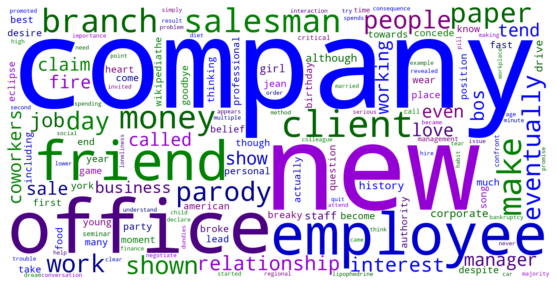

Wordcloud for Jim_Halpert


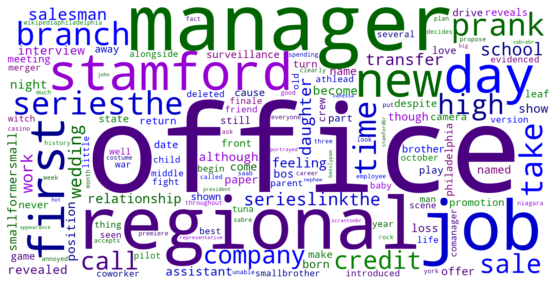

Wordcloud for Dwight_Schrute


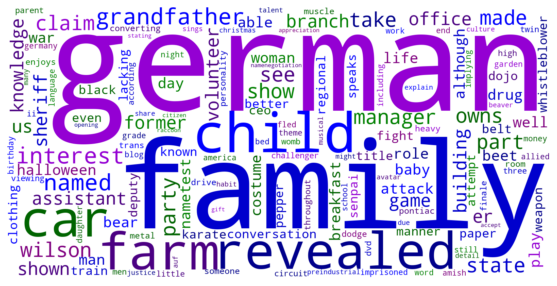

Wordcloud for Pam_Beesly


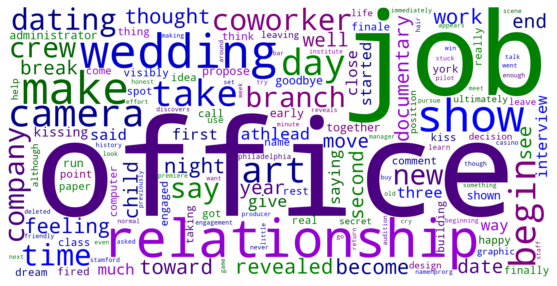

Wordcloud for Andy_Bernard


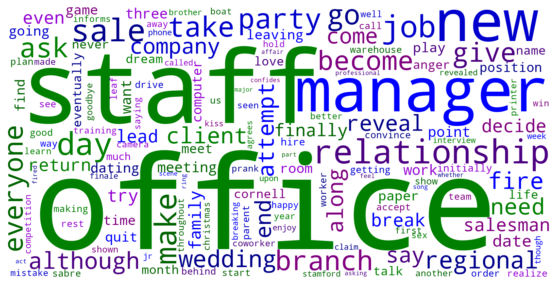

In [83]:
characters_to_analyze = ["Michael_Scott", "Jim_Halpert", "Dwight_Schrute", "Pam_Beesly", "Andy_Bernard"]

for character in characters_to_analyze:
    output = get_token_text_wiki_page(character)    
    print(f"Wordcloud for {character}")
    make_wordcloud(output,character)

In [24]:
def get_characters_lines():
    characters_all = ["Michael", "Jim", "Pam", "Dwight", "Angela", "Oscar", "Kevin", "Andy", "Erin", "Phyllis", "Darryl",
                     "Stanley", "Toby", "Kelly", "Ryan"]
    character_lines_all = {}

    for character in characters_all:
        episode_lines = get_character_lines_per_episode(character, remove_par = False)
        character_lines_all[character] = "".join(str(lines) for episode in episode_lines.values() for lines in episode.values())

In [25]:
def get_characters_relations():

    from collections import Counter
    character_lines_all = get_characters_lines()
    character_relations = {}
    char_lower = [c.lower() for c in characters_all]

    for character in characters_all: 
        text = character_lines_all[character]
        text = [token for token in tokenize_text(text) if token in char_lower]
        counter = Counter(text)
        relations = {}      
        character_relations[character.lower()] = dict(counter)

In [26]:
'''
with open('Data/interaction_dict.pickle', 'wb') as handle:
    pickle.dump(character_relations, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

"\nwith open('Data/interaction_dict.pickle', 'wb') as handle:\n    pickle.dump(character_relations, handle, protocol=pickle.HIGHEST_PROTOCOL)\n"

In [27]:
with open('Data/interaction_dict.pickle', 'rb') as handle:
    character_relations = pickle.load(handle)

In [28]:
def capitalize(w):
    return w[0].upper() + w[1:]

In [29]:
G = nx.Graph()
#G.add_nodes_from(character_relations.keys())
G.add_edges_from([(capitalize(char),capitalize(link), {'Weight': weight}) for (char,val) in character_relations.items() for (link,weight) in val.items()])

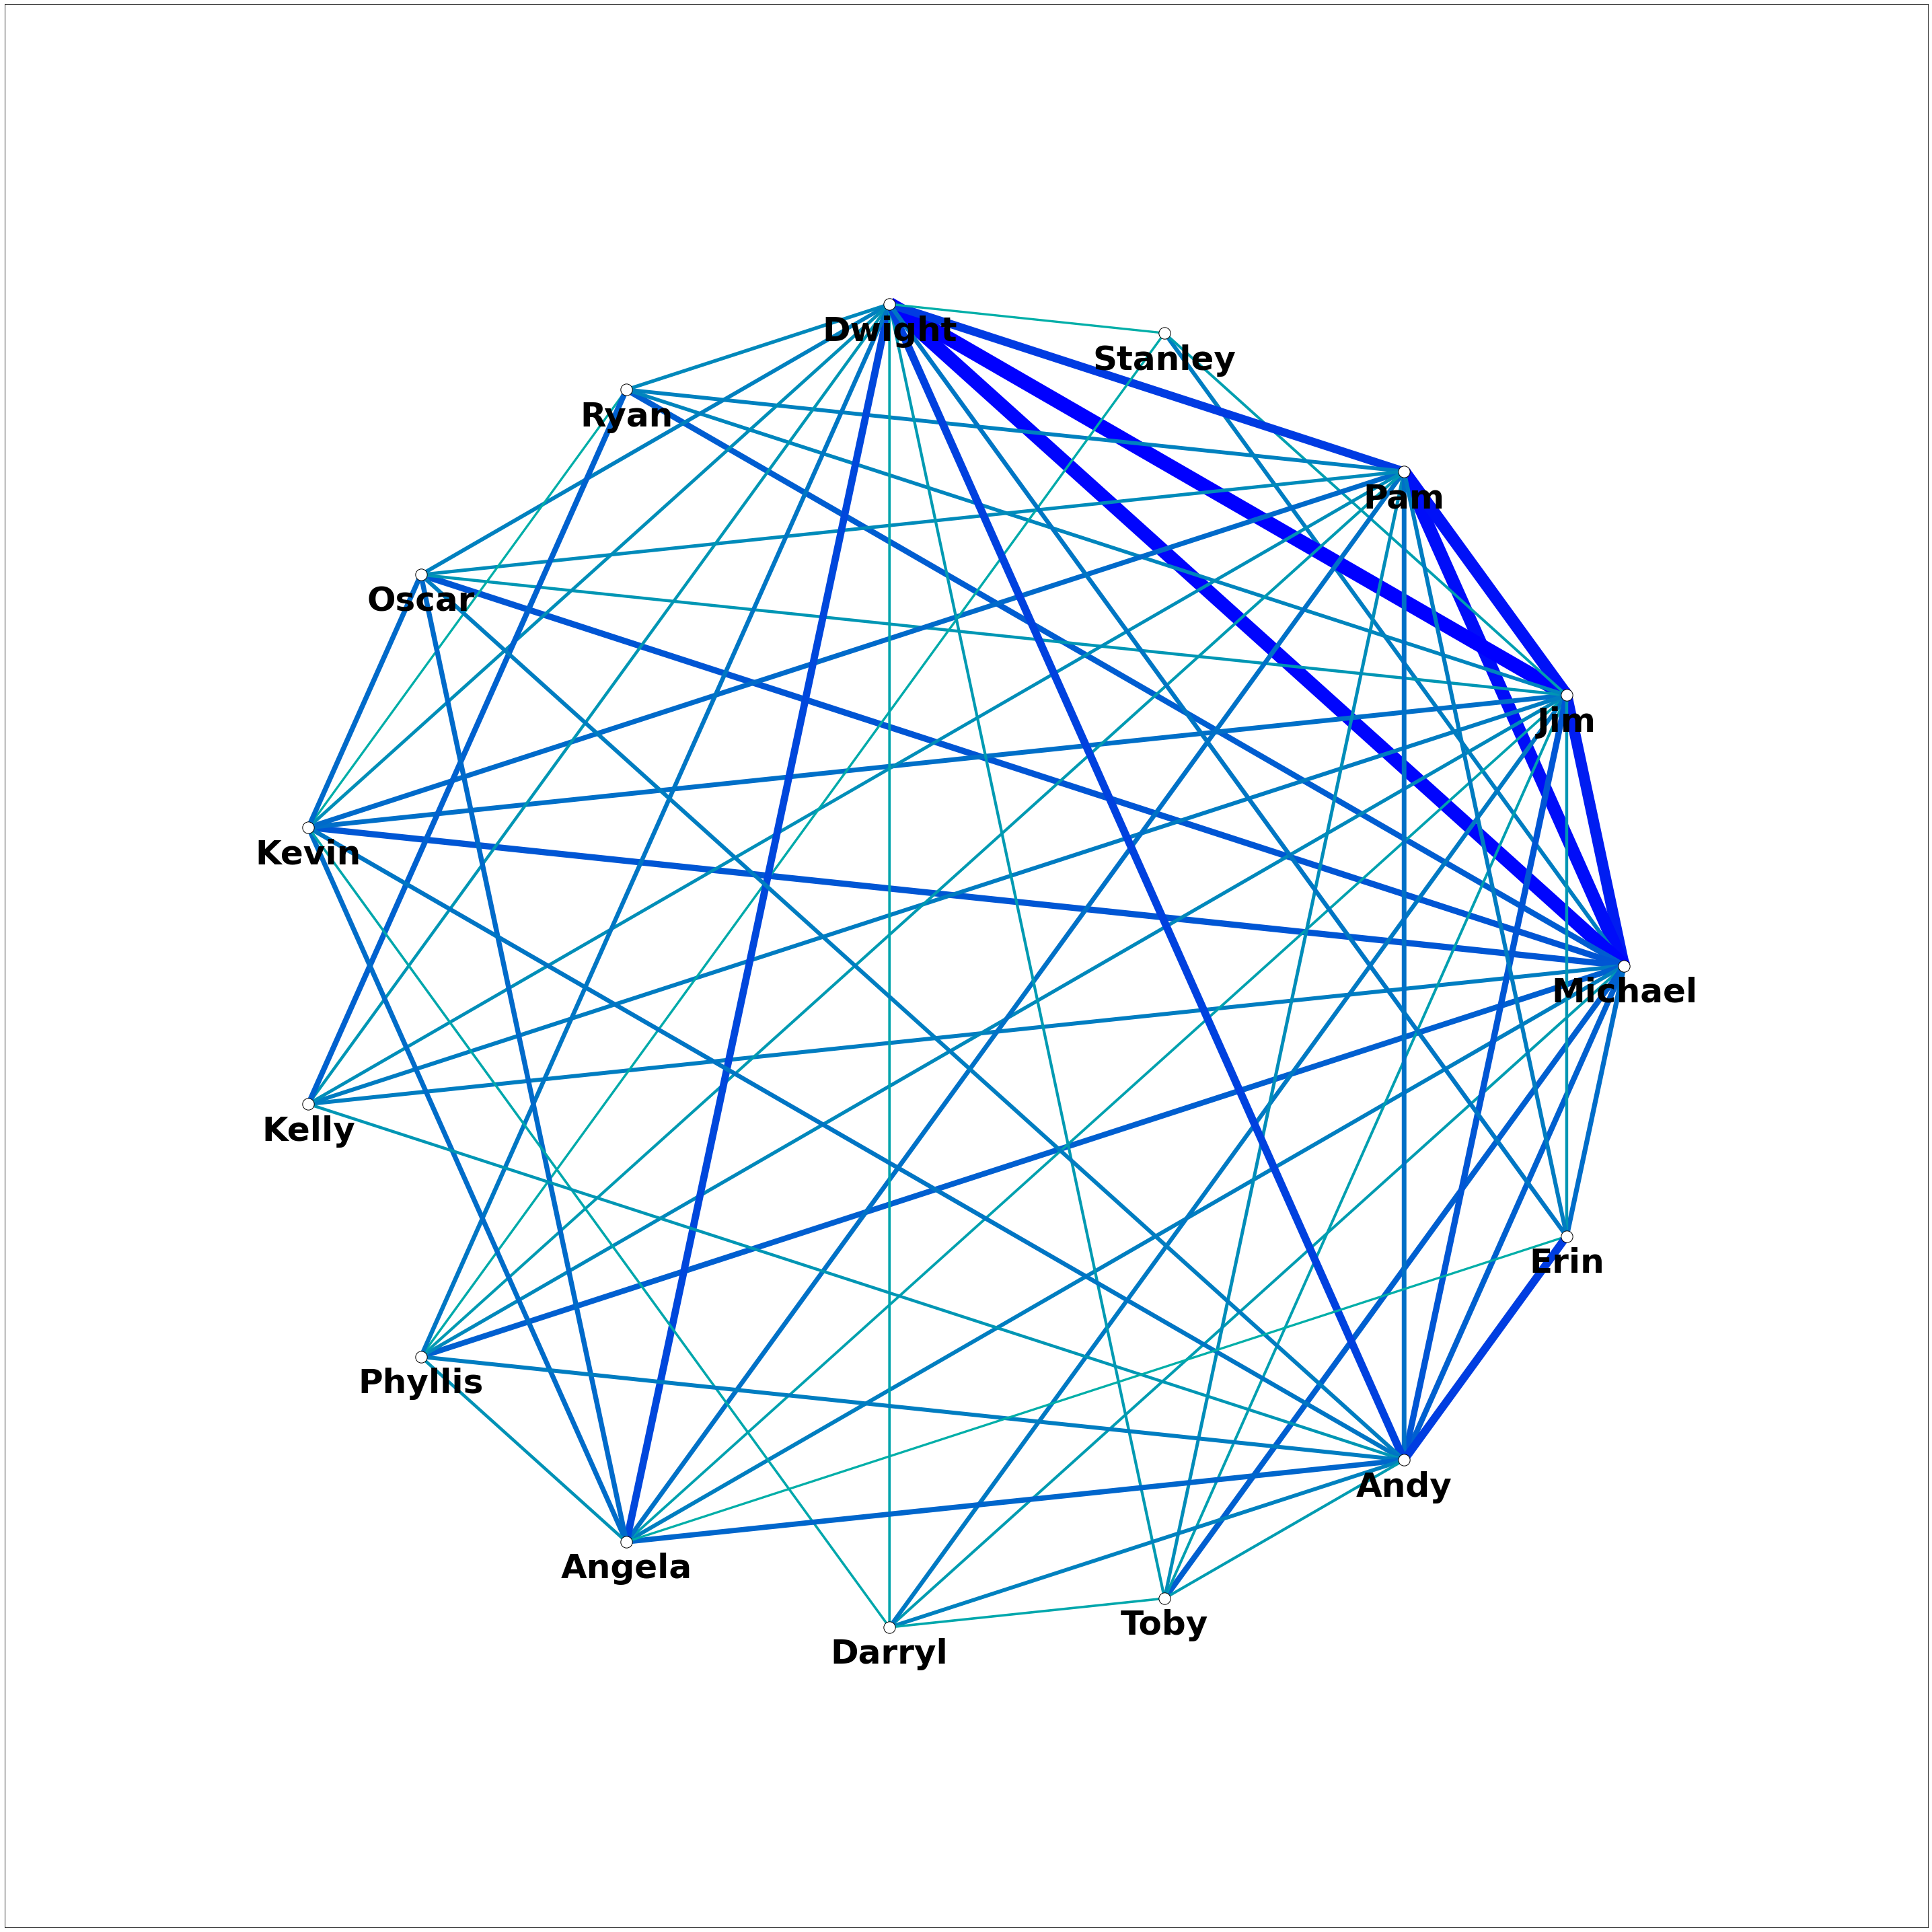

In [121]:

def plot_fig_para(G):
    plt.figure(figsize=(40, 40))
    pos = nx.circular_layout(G)
    
    edges = G.edges()

    colors = [G[u][v]['Weight']**0.1 for u, v in edges]

    weights = [G[u][v]['Weight']**0.5 if G[u][v]['Weight'] > 10 else 0 for u, v in edges]
    

    cmap = matplotlib.cm.get_cmap('winter_r')
    nx.draw_networkx(G, pos, width=weights, edge_color=colors,
                     node_color="white", edge_cmap=cmap, with_labels=False)

    labels_pos = {name: [pos_list[0], pos_list[1]-0.04] for name, pos_list in pos.items()}
    nd = nx.draw_networkx_labels(G, labels_pos, font_size=50, font_family="sans-serif",
                            font_color="#000000", font_weight='bold')

    ax = plt.gca()
    ax.collections[0].set_edgecolor('#000000')
    ax.margins(0.25)
    plt.axis("equal")
    plt.tight_layout()

plot_fig_para(G)
plt.savefig(folder2 + "characters_interactions.png")
plt.show()

### Collocations

In [110]:
characters_to_analyze = ["michael", "pam", "jim", "dwight"]

In [111]:
def get_lines(character):
    path = "Data/character_lines/"
    text = []
    folder = path + character + "/"
    for file in os.listdir(folder):
        tsv_file = open(folder + file,encoding="utf8")
        read_tsv = csv.reader(tsv_file, delimiter="\n")

        text.append([row[0] for row in read_tsv])
        
    return text

In [112]:
def get_tokens(characters_to_analyze):
    characters_tokens = {}
    
    for character in characters_to_analyze:
        texts = get_lines(character)
        tokens = [tokenize_sentences(text) for text in texts]

        characters_tokens[character] = tokens
    return characters_tokens

In [113]:
Michael_Text = " ".join(["".join(line) for line in get_lines("michael")])

In [114]:
Michael_Text.lower()

' all right jim. your quarterlies look very good. how are things at the library? so youve come to the master for guidance? is this what youre saying, grasshopper? all right. well, let me show you how its done.  yes, id like to speak to your office manager, please. yes, hello. this is michael scott. i am the regional manager of dunder mifflin paper products. just wanted to talk to you manager-a-manger.  all right. done deal. thank you very much, sir. youre a gentleman and a scholar. oh, im sorry. ok. im sorry. my mistake.  that was a woman i was talking to, so... she had a very low voice. probably a smoker, so...  so thats the way its done. ive, uh, ive been at dunder mifflin for 12 years, the last four as regional manager. if you want to come through here... see we have the entire floor. so this is my kingdom, as far as the eye can see. this is our receptionist, pam. pam! pam-pam! pam beesly. pam has been with us for...  forever. right, pam? if you think shes cute now, you should have 

In [117]:
len(re.findall("thats what she said", Michael_Text.lower()))

24

In [36]:
characters_tokens = get_tokens(characters_to_analyze)

In [70]:
x = " ".join([word.lower() for words in get_lines("michael") for word in words])

In [71]:
z = punctuation.replace("'","")

In [72]:
x = re.split(f'[{z}\s]+', x)

In [73]:
MichaelText = nltk.Text(x)

In [74]:
MichaelText.collocations()

dunder mifflin; michael scott; dont know; little bit; new york; hey
hey; conference room; beep beep; would like; david wallace; regional
manager; ice cream; paper company; blah blah; whoa whoa; yeah yeah;
okay okay; dont want; dont think; wait wait


In [78]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
fourgram_measures = nltk.collocations.QuadgramAssocMeasures()

# change this to read in your data
finder = QuadgramCollocationFinder.from_words(x)

# only bigrams that appear 3+ times
finder.apply_freq_filter(3)

# return the 10 n-grams with the highest PMI
finder.nbest(fourgram_measures.pmi, 10)

[('dun', 'der', 'dun', 'der'),
 ('enabler', 'enabler', 'enabler', 'enabler'),
 ('der', 'dun', 'der', 'dun'),
 ('gimme', 'gimme', 'gimme', 'gimme'),
 ('beep', 'beep', 'beep', 'beep'),
 ('magic', 'magic', 'magic', 'magic'),
 ('la', 'la', 'la', 'la'),
 ('da', 'na', 'na', 'na'),
 ('na', 'da', 'na', 'na'),
 ('na', 'na', 'da', 'na')]